In [1]:
!pip install tinydb 
!pip install pandas_ta
!pip install python-binance
# !pip install yfinance
!pip install mplfinance

In [2]:
from tinydb import TinyDB, Query
import os
import sys
import json
# from dotenv import load_dotenv
import asyncio
import threading
import datetime as dt
from multiprocessing import Pool, cpu_count

# Other modules
import pandas as pd
import pandas_ta as ta
from pandas.io import sql
import numpy as np
import matplotlib.pyplot as plt

# python-binance module
from binance.client import Client
from binance import BinanceSocketManager
from binance.enums import *

# BINANCE_KEY = os.getenv('BINANCE_KEY')
# BINANCE_SECRET = os.getenv('BINANCE_SECRET')
BINANCE_KEY = ''
BINANCE_SECRET = ''

# connect binance
client = Client(BINANCE_KEY, BINANCE_SECRET)

import time
db = TinyDB('ta_report.json')
Record = Query()

from enum import Enum

class Colors(Enum):
    green = 1
    grey = 0
    red = -1

def insertNewRecord(record):
    db.insert(record)
    
    
def update_or_create(record):
    symbol = record.get('symbol')
    if(not symbol):
        raise Exception('symbol is undefined')
    
    found = len(db.search(Record.symbol == symbol))
    if found > 0:
        db.update(record, Record.key == symbol)
    else:
        db.insert(record)

In [3]:
# ==================GET PRICES FUNCTIONS======================

def get_token_usdt_pair():
    tickers = client.get_all_tickers()
    symbols = []
    for s in tickers:
        symbolPair = s['symbol']
        price = float(s['price'])
        if('USDT' in symbolPair and 'DOWN' not in symbolPair 
                # and price > 0.01
                and price < 10
                and 'UP' not in symbolPair):
            if(symbolPair.startswith('USDT')):
                continue
            else:
                symbols.append(symbolPair)

    return symbols

def _convertFloat(dataframe):
    dataframe['open'] = dataframe['open'].astype(float)
    dataframe['high'] = dataframe['high'].astype(float)
    dataframe['low'] = dataframe['low'].astype(float)
    dataframe['close'] = dataframe['close'].astype(float)
    dataframe['volume'] = dataframe['volume'].astype(float)
    return dataframe


def prepare_data():
    symbols = get_token_usdt_pair()
    # symbols = ['RAMPUSDT','ADAUSDT','XRPUSDT']
    df = pd.DataFrame()
    for symbol in symbols:
        df1 = pd.DataFrame(client.get_historical_klines(symbol,
                                                       client.KLINE_INTERVAL_1HOUR,
                                                       "7 day ago UTC"
                                                       ))
        if(len(df1) != 0):
            df1.columns = ["date", "open", "high", "low", "close", "volume",
                          "close_time", "qav", "num_trades", "taker_base_vol",
                          "taker_quote_vol", "is_best_match"]

            df1["timestamp"] = df1.date
            df1["timestamp_str"] = [dt.datetime.fromtimestamp(x / 1000) for x in df1.date]
            df1['symbol'] = symbol
            newDf = df1.filter(["symbol","timestamp","timestamp_str", "open", "high", "low",
                              "close", "volume"], axis=1, )

            # Convert float
            convertedNewDf = _convertFloat(newDf)
        df = pd.concat([df, convertedNewDf])
        print(symbol)
    df.to_csv('data_to_analyse.csv')




In [4]:
prepare_data()

QTUMUSDT
ADAUSDT
XRPUSDT
EOSUSDT
TUSDUSDT
IOTAUSDT
XLMUSDT
ONTUSDT
TRXUSDT
ICXUSDT
VENUSDT
NULSUSDT
VETUSDT
PAXUSDT
USDCUSDT
BTTUSDT
USDSUSDT
ONGUSDT
HOTUSDT
ZILUSDT
ZRXUSDT
FETUSDT
BATUSDT
IOSTUSDT
CELRUSDT
NANOUSDT
OMGUSDT
THETAUSDT
ENJUSDT
MITHUSDT
MATICUSDT
TFUELUSDT
ONEUSDT
FTMUSDT
ALGOUSDT
USDSBUSDT
GTOUSDT
ERDUSDT
DOGEUSDT
DUSKUSDT
ANKRUSDT
WINUSDT
COSUSDT
NPXSUSDT
COCOSUSDT
MTLUSDT
TOMOUSDT
PERLUSDT
DENTUSDT
MFTUSDT
KEYUSDT
STORMUSDT
DOCKUSDT
WANUSDT
FUNUSDT
CVCUSDT
CHZUSDT
BANDUSDT
BUSDUSDT
BEAMUSDT
XTZUSDT
RENUSDT
RVNUSDT
HCUSDT
HBARUSDT
NKNUSDT
STXUSDT
KAVAUSDT
ARPAUSDT
IOTXUSDT
RLCUSDT
MCOUSDT
CTXCUSDT
TROYUSDT
VITEUSDT
BUSDTRY
EURUSDT
OGNUSDT
DREPUSDT
TCTUSDT
WRXUSDT
BTSUSDT
LSKUSDT
BNTUSDT
LTOUSDT
EOSBULLUSDT
XRPBULLUSDT
STRATUSDT
AIONUSDT
MBLUSDT
COTIUSDT
STPTUSDT
WTCUSDT
DATAUSDT
XZCUSDT
CTSIUSDT
HIVEUSDT
CHRUSDT
GXSUSDT
ARDRUSDT
LENDUSDT
MDTUSDT
STMXUSDT
KNCUSDT
LRCUSDT
PNTUSDT
BKRWUSDT
SCUSDT
VTHOUSDT
DGBUSDT
GBPUSDT
SXPUSDT
DAIUSDT
STORJUSDT
MANAUSDT
AUDUSDT
BLZUSDT


In [5]:
df_0 = pd.read_csv('data_to_analyse.csv')
df_0.rename(columns={'timestamp_str': 'Date', 'open': 'Open', 'high': 'High','low': 'Low', 'close': 'Close'}, inplace=True)
df_0.tail(5)

,Unnamed: 0,symbol,timestamp,Date,Open,High,Low,Close,volume
36115,163,GALAUSDT,1632279600000,2021-09-22 10:00:00,0.10320,0.10852,0.10318,0.10417,122355698.0
36116,164,GALAUSDT,1632283200000,2021-09-22 11:00:00,0.10416,0.10542,0.10220,0.10231,58971692.0
36117,165,GALAUSDT,1632286800000,2021-09-22 12:00:00,0.10240,0.10567,0.10226,0.10434,65688623.0
36118,166,GALAUSDT,1632290400000,2021-09-22 13:00:00,0.10428,0.10830,0.10294,0.10750,84603092.0
36119,167,GALAUSDT,1632294000000,2021-09-22 14:00:00,0.10745,0.10911,0.10600,0.10800,56904341.0


In [6]:
import pandas as pd
import numpy as np
import math
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
df = pd.read_csv('data_to_analyse.csv')
df.rename(columns={'timestamp_str': 'Date', 'open': 'Open', 'high': 'High','low': 'Low', 'close': 'Close'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].apply(mpl_dates.date2num)
df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
df.head()

,Date,Open,High,Low,Close
0,18885.625000,12.681,12.750,12.597,12.617
1,18885.666667,12.615,12.668,12.582,12.594
2,18885.708333,12.594,12.784,12.594,12.741
3,18885.750000,12.741,12.747,12.645,12.710
4,18885.791667,12.711,12.760,12.584,12.612


In [7]:
#method 1: fractal candlestick pattern
# determine bullish fractal 
def is_support(df,i):  
  cond1 = df['Low'][i] < df['Low'][i-1]   
  cond2 = df['Low'][i] < df['Low'][i+1]   
  cond3 = df['Low'][i+1] < df['Low'][i+2]   
  cond4 = df['Low'][i-1] < df['Low'][i-2]  
  return (cond1 and cond2 and cond3 and cond4) 
# determine bearish fractal
def is_resistance(df,i):  
  cond1 = df['High'][i] > df['High'][i-1]   
  cond2 = df['High'][i] > df['High'][i+1]   
  cond3 = df['High'][i+1] > df['High'][i+2]   
  cond4 = df['High'][i-1] > df['High'][i-2]  
  return (cond1 and cond2 and cond3 and cond4)
# to make sure the new level area does not exist already
def is_far_from_level(value, levels, df):    
  ave =  np.mean(df['High'] - df['Low'])    
  return np.sum([abs(value-level)<ave for _,level in levels])==0
# a list to store resistance and support levels
levels = []
for i in range(2, df.shape[0] - 2):  
  if is_support(df, i):    
    low = df['Low'][i]    
    if is_far_from_level(low, levels, df):      
      levels.append((i, low))  
  elif is_resistance(df, i):    
    high = df['High'][i]    
    if is_far_from_level(high, levels, df):      
      levels.append((i, high))

In [8]:
# for visualization
def plot_all(levels, df):    
  fig, ax = plt.subplots(figsize=(16, 9))   
#   candlestick_ohlc(ax,df.values,width=0.6, colorup='green', 
#     colordown='red', alpha=0.8)    
  candlestick_ohlc(ax,df.values,colorup='green')    
  date_format = mpl_dates.DateFormatter('%d %b %Y')
  ax.xaxis.set_major_formatter(date_format)    
  for level in levels:        
    plt.hlines(level[1], xmin = df['Date'][level[0]], xmax = 
      max(df['Date']), colors='blue', linestyle='--')    
  fig.show()

In [9]:
df = pd.read_csv('data_to_analyse.csv')
df.rename(columns={'symbol': 'Symbol','timestamp_str': 'Date', 'open': 'Open', 'high': 'High','low': 'Low', 'close': 'Close'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].apply(mpl_dates.date2num)
df = df[df.Symbol=='NEARUSDT']
df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
df.head()

,Date,Open,High,Low,Close
23520,18885.625000,9.249,9.302,9.052,9.081
23521,18885.666667,9.081,9.170,8.957,9.037
23522,18885.708333,9.036,9.154,8.971,9.060
23523,18885.750000,9.061,9.086,8.879,8.960
23524,18885.791667,8.961,8.973,8.774,8.807


In [14]:
df.to_csv('NEARUSDT.csv')

In [22]:
df_csv = pd.read_csv('NEARUSDT.csv')
df_csv

,Unnamed: 0,Date,Open,High,Low,Close
0,23520,18885.625000,9.249,9.302,9.052,9.081
1,23521,18885.666667,9.081,9.170,8.957,9.037
2,23522,18885.708333,9.036,9.154,8.971,9.060
3,23523,18885.750000,9.061,9.086,8.879,8.960
4,23524,18885.791667,8.961,8.973,8.774,8.807
...,...,...,...,...,...,...
163,23683,18892.416667,6.962,7.056,6.918,6.931
164,23684,18892.458333,6.931,6.948,6.684,6.730
165,23685,18892.500000,6.733,6.871,6.733,6.827
166,23686,18892.541667,6.826,7.004,6.724,6.988


In [25]:
df_csv = pd.read_csv('NEARUSDT.csv')
df_csv = df_csv.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
df_csv

,Date,Open,High,Low,Close
0,18885.625000,9.249,9.302,9.052,9.081
1,18885.666667,9.081,9.170,8.957,9.037
2,18885.708333,9.036,9.154,8.971,9.060
3,18885.750000,9.061,9.086,8.879,8.960
4,18885.791667,8.961,8.973,8.774,8.807
...,...,...,...,...,...
163,18892.416667,6.962,7.056,6.918,6.931
164,18892.458333,6.931,6.948,6.684,6.730
165,18892.500000,6.733,6.871,6.733,6.827
166,18892.541667,6.826,7.004,6.724,6.988


In [29]:
df =df_csv
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    168 non-null    float64
 1   Open    168 non-null    float64
 2   High    168 non-null    float64
 3   Low     168 non-null    float64
 4   Close   168 non-null    float64
dtypes: float64(5)
memory usage: 6.7 KB


<ipython-input-8-048204290d91>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


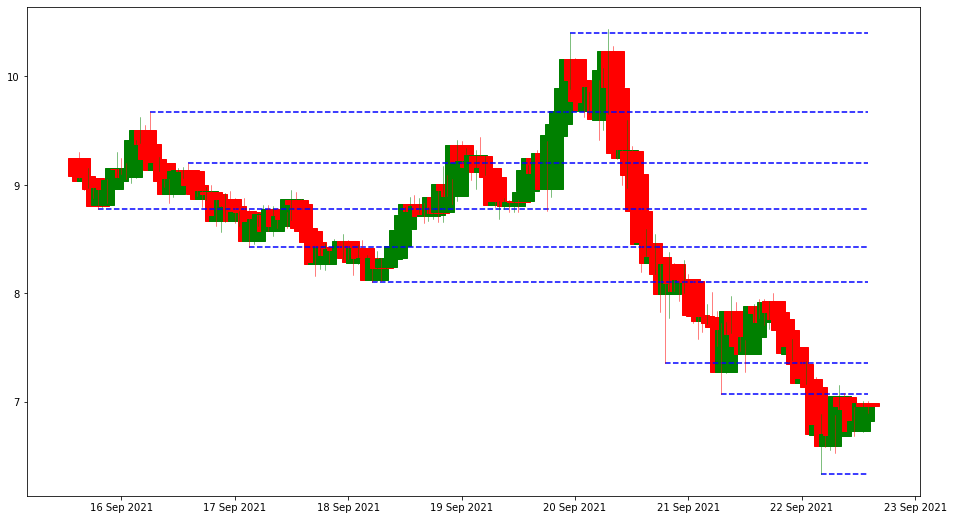

In [28]:
#method 2: window shifting method
#using the same symbol as the first example above
symbol = 'COST'
# df = get_stock_price(symbol)

# df = pd.read_csv('stock.csv')
pivots = []
max_list = []
min_list = []
for i in range(5, len(df)-5):
  # taking a window of 9 candles
  high_range = df['High'][i-5:i+4]
  current_max = high_range.max()
  # if we find a new maximum value, empty the max_list 
  if current_max not in max_list:
    max_list = []
  max_list.append(current_max)
  # if the maximum value remains the same after shifting 5 times
  if len(max_list)==5 and is_far_from_level(current_max,pivots,df):
      pivots.append((high_range.idxmax(), current_max))
    
  low_range = df['Low'][i-5:i+5]
  current_min = low_range.min()
  if current_min not in min_list:
    min_list = []
  min_list.append(current_min)
  if len(min_list)==5 and is_far_from_level(current_min,pivots,df):
    pivots.append((low_range.idxmin(), current_min))
plot_all(pivots, df)

In [11]:
pivots
values = []
for element in pivots:
    _, value =  element
    values.append(value)
values.sort()
values

[6.337999999999999,
 7.067,
 7.353,
 8.107999999999999,
 8.43,
 8.774,
 9.2,
 9.67,
 10.4]